# Решающее дерево

## Подключение библиотек

In [5]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt

## 1. Данные

### Разделение данных на тренировочные и тестовые

In [6]:
features_train = []
prices = []

with open('./dataset/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    for row in reader:
        sale_price = float(row['Survived'])
        feature_values = []
        for feature in feature_titles:
            value = row[feature]
            feature_values.append(float(value))
        
        features_train.append(feature_values)
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
scaler = StandardScaler()

for i, feature in enumerate(feature_titles):
    if feature in numerical_features:
        mean_value = np.nanmean(x_train[:, i])
        x_train[:, i] = np.where(np.isnan(x_train[:, i]), mean_value, x_train[:, i])
        x_test[:, i] = np.where(np.isnan(x_test[:, i]), mean_value, x_test[:, i])
        
        x_train[:, i] = scaler.fit_transform(x_train[:, i].reshape(-1, 1)).flatten()
        x_test[:, i] = scaler.transform(x_test[:, i].reshape(-1, 1)).flatten()

### Визуализация данных

In [7]:
table_data = []
headers = ["Index"] + feature_titles + ["Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="left"))

+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| Index   | Pclass   | Sex   | Age        | SibSp     | Parch     | Fare        | Embarked   | Survived   |
+=========+==========+=======+============+===========+===========+=============+============+============+
| 0       | 1        | 0     | -1.85798   | -0.474161 | 1.99885   | 0.980998    | 2          | 1          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 1       | 3        | 0     | -0.278303  | -0.474161 | -0.479327 | -0.469634   | 2          | 0          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 2       | 3        | 1     | -2.08365   | 0.348687  | 0.759763  | -0.406136   | 2          | 1          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 3       | 2        | 0    

### Оставляем только два признака (Age, Fare)

In [ ]:
x_train = x_train[:, [2, 5]]
x_test = x_test[:, [2, 5]]

### Визуализируем оставшиеся данные

In [ ]:
table_data = []
headers = ["Index", "Age", "Fare", "Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="left"))

+---------+------------+-------------+------------+
| Index   | Age        | Fare        | Survived   |
+=========+============+=============+============+
| 0       | -1.85798   | 0.980998    | 1          |
+---------+------------+-------------+------------+
| 1       | -0.278303  | -0.469634   | 0          |
+---------+------------+-------------+------------+
| 2       | -2.08365   | -0.406136   | 1          |
+---------+------------+-------------+------------+
| 3       | 0.549149   | -0.0802318  | 0          |
+---------+------------+-------------+------------+
| 4       | 1.07571    | -0.109651   | 0          |
+---------+------------+-------------+------------+
| 5       | 0.699595   | 2.38538     | 0          |
+---------+------------+-------------+------------+
| 6       | 0.173034   | -0.109651   | 1          |
+---------+------------+-------------+------------+
| 7       | 0.0225886  | -0.466609   | 0          |
+---------+------------+-------------+------------+
| 8       | 

## 2. Построение модели

In [ ]:
class DecisionTree:
    def __init__(self, iterations=10**100, lr=0.001, eps=1e-6, depth=3, degree=1):
        self.iterations = iterations
        self.lr = lr
        self.eps = eps
        self.depth = depth
        self.degree = degree
        self._weights = None    
        self._gradHistory = []
        
    def _addIntercept(self, X) -> None:
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def _addPolynomialFeatures(self, X) -> None:
        if self.degree <= 1:
            return X  
        poly_features = [X ** i for i in range(1, self.degree + 1)]
        return np.hstack(poly_features)      
    
    def fit(self, X, Y) -> None:
        self._gradHistory.clear()
        min_impurity = 10
        for i in range(X.shape[1]):
            feature = X[:, i]
            if(self._is_categorical(feature)):
                print('Categorical feauture')
            elif(self._is_binary(feature)):
                print('Binary feauture')
            else: # numerical
                sorted_indices = np.argsort(feature)
                sorted_features = feature[sorted_indices]
                sorted_targets = Y[sorted_indices]
                averages = [(sorted_features[j] + sorted_features[j + 1]) / 2 for j in range(len(sorted_features) - 1)]
                impurities = []

                for _, threshold in enumerate(averages):
                    left_branch_targets = sorted_targets[sorted_features <= threshold]
                    right_branch_targets = sorted_targets[sorted_features > threshold]
                
                    left_branch_surv_chance = left_branch_targets.sum() / len(left_branch_targets)
                    left_branch_impurity = 2 * left_branch_surv_chance * (1 - left_branch_surv_chance)

                    right_branch_surv_chance = right_branch_targets.sum() / len(right_branch_targets)
                    right_branch_impurity = 2 * right_branch_surv_chance * (1 - right_branch_surv_chance)

                    total_impurity = len(left_branch_targets) / len(Y) * left_branch_impurity + \
                                    len(right_branch_targets) / len(Y) * right_branch_impurity
                    impurities.append(total_impurity)
                
                best_impurity = impurities[np.argmin(impurities)]
                best_threshold = averages[np.argmin(impurities)]
                if(min_impurity > best_impurity):
                    min_impurity = best_impurity
                    self.best_feature_index = i
                    self.best_threshold = best_threshold
                
    def _is_categorical(self, feature) -> bool: 
        unique_values = np.unique(feature)
        num_unique = len(unique_values)
        if(num_unique / len(feature) < 0.1):
            return True
        return False
    
    def _is_binary(self, feature) -> bool:
        unique_values = np.unique(feature)
        num_unique = len(unique_values)
        if(num_unique == 2):
            return True
        return False
        
    def getGradHistory(self) -> list:
        return self._gradHistory
    
    def getWeights(self) -> list:
        return self._weights    

## 3. Тренировка 

## 4. Оценка качества модели

## 5. Визуализация модели

#### Примеры визуализации

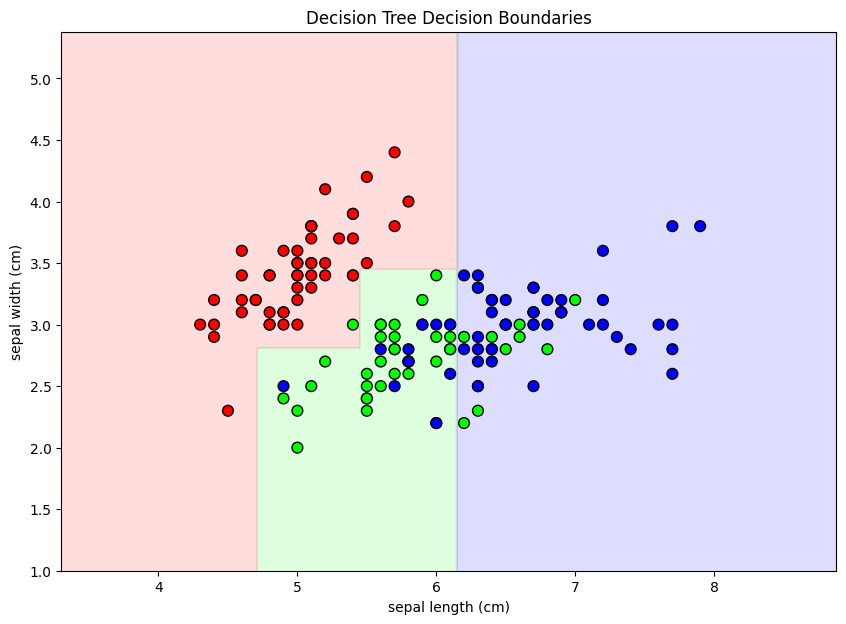

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import load_iris
# from sklearn.tree import DecisionTreeClassifier
# from matplotlib.colors import ListedColormap

# # Загрузка датасета Iris
# iris = load_iris()
# X = iris.data[:, :2]  # Берем только первые два признака
# y = iris.target       # Метки классов
# feature_names = iris.feature_names[:2]
# class_names = iris.target_names

# # Создание модели решающего дерева
# clf = DecisionTreeClassifier(max_depth=3, random_state=42)
# clf.fit(X, y)

# # Определение границ графика
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# # Создание сетки для построения разбиений
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
#                      np.arange(y_min, y_max, 0.02))

# # Предсказание классов для каждой точки сетки
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Создание цветовой карты
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
# cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# # Построение разбиений областей
# plt.figure(figsize=(10, 7))
# plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

# # Построение точек данных
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=60)

# # Добавление подписей
# plt.xlabel(feature_names[0])
# plt.ylabel(feature_names[1])
# plt.title("Decision Tree Decision Boundaries")

# # Отображение графика
# plt.show()

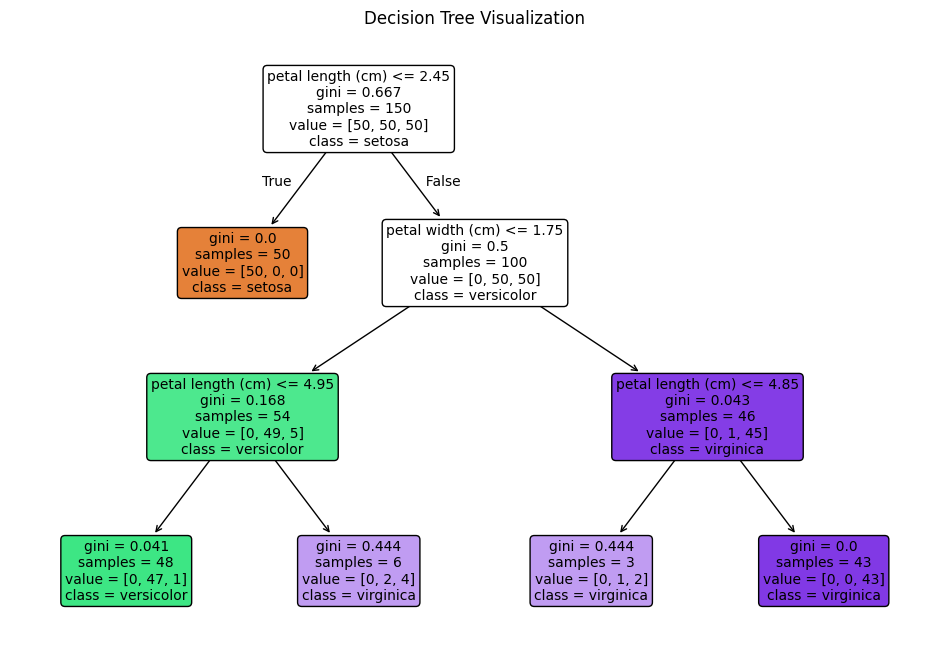

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import load_iris
# from sklearn.tree import DecisionTreeClassifier, plot_tree

# iris = load_iris()
# X = iris.data  
# y = iris.target 
# feature_names = iris.feature_names 
# class_names = iris.target_names 

# clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# clf.fit(X, y)

# plt.figure(figsize=(12, 8))
# plot_tree(clf, 
#           feature_names=feature_names, 
#           class_names=class_names, 
#           filled=True, 
#           rounded=True,  
#           fontsize=10) 

# plt.title("Decision Tree Visualization")
# plt.show()